# Домашнее задание 2: Создание и оптимизация ResNet18


In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from pathlib import Path
from collections import defaultdict
import random
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support


def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
set_seed(42)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print({device})

{device(type='cuda')}


## 1. Подготовка данных

In [2]:
class TinyImageNetDataset(Dataset):
    def __init__(self, root_dir, split='train', selected_classes=None, transform=None):
        self.root_dir = Path(root_dir)
        self.split = split
        self.transform = transform
        self.selected_classes = selected_classes
        self.images = []
        self.labels = []
        self.class_to_idx = {}
        if selected_classes:
            self.class_to_idx = {cls: idx for idx, cls in enumerate(sorted(selected_classes))}
        self._load_data()
    
    def _load_data(self):
        if self.split == 'train':
            train_dir = self.root_dir / 'train'
            for class_dir in sorted(train_dir.iterdir()):
                if class_dir.is_dir():
                    class_name = class_dir.name
                    if self.selected_classes and class_name not in self.selected_classes:
                        continue
                    if class_name not in self.class_to_idx:
                        self.class_to_idx[class_name] = len(self.class_to_idx)
                    images_dir = class_dir / 'images'
                    if images_dir.exists():
                        for img_path in images_dir.glob('*.JPEG'):
                            self.images.append(str(img_path))
                            self.labels.append(self.class_to_idx[class_name])
        elif self.split == 'val':
            val_dir = self.root_dir / 'val'
            val_annotations = val_dir / 'val_annotations.txt'
            with open(val_annotations, 'r') as f:
                for line in f:
                    parts = line.strip().split('\t')
                    img_name = parts[0]
                    class_name = parts[1]
                    if self.selected_classes and class_name not in self.selected_classes:
                        continue
                    if class_name not in self.class_to_idx:
                        self.class_to_idx[class_name] = len(self.class_to_idx)
                    img_path = val_dir / 'images' / img_name
                    if img_path.exists():
                        self.images.append(str(img_path))
                        self.labels.append(self.class_to_idx[class_name])
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img_path = self.images[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

In [3]:
DATA_DIR = 'tiny-imagenet-200'
# BATCH_SIZE = 8
# NUM_EPOCHS = 30
# LEARNING_RATE = 0.001
# NUM_WORKERS = 0 

BATCH_SIZE = 8
NUM_EPOCHS = 25
LEARNING_RATE = 0.001
NUM_WORKERS = 0


SELECTED_CLASSES = [
    'n01443537', 'n01629819', 'n01641577', 'n01644900', 'n01698640',
    'n01742172', 'n01768244', 'n01770393', 'n01774384', 'n01774750'
]

CLASS_NAMES = [
    'goldfish', 'salamander', 'bullfrog', 'tailed_frog', 'alligator',
    'boa', 'trilobite', 'scorpion', 'black_widow', 'tarantula'
]

print(f" Выбранные классы: {CLASS_NAMES}")

train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(64, padding=4),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])


train_dataset = TinyImageNetDataset(DATA_DIR, split='train', selected_classes=SELECTED_CLASSES, transform=train_transform)
val_dataset = TinyImageNetDataset(DATA_DIR, split='val', selected_classes=SELECTED_CLASSES, transform=val_transform)
test_dataset = TinyImageNetDataset(DATA_DIR, split='val', selected_classes=SELECTED_CLASSES, transform=val_transform) 

print(f"Размер train dataset: {len(train_dataset)}")
print(f"Размер validation dataset: {len(val_dataset)}")

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

 Выбранные классы: ['goldfish', 'salamander', 'bullfrog', 'tailed_frog', 'alligator', 'boa', 'trilobite', 'scorpion', 'black_widow', 'tarantula']
Размер train dataset: 5000
Размер validation dataset: 500


## ResNet18

In [4]:
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, activation='relu'):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = None
        if stride != 1 or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
        self.activation = self._get_activation(activation)
    
    def _get_activation(self, activation):
        if activation == 'leakyrelu': return nn.LeakyReLU(inplace=True)
        if activation == 'elu': return nn.ELU(inplace=True)
        if activation == 'gelu': return nn.GELU()
        return nn.ReLU(inplace=True)
    
    def forward(self, x):
        identity = x
        out = self.activation(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        if self.downsample is not None:
            identity = self.downsample(x)
        out += identity
        return self.activation(out)

class ResNet18(nn.Module):
    def __init__(self, num_classes=10, channels=[64, 128, 256, 512], num_blocks=[2, 2, 2, 2], activation='relu', use_maxpool=False):
        super(ResNet18, self).__init__()
        self.in_channels = channels[0]
        self.activation_name = activation
        
        if use_maxpool:
            self.conv1 = nn.Conv2d(3, channels[0], kernel_size=7, stride=2, padding=3, bias=False)
            self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        else:
            self.conv1 = nn.Conv2d(3, channels[0], kernel_size=3, stride=1, padding=1, bias=False)
            self.maxpool = None
            
        self.bn1 = nn.BatchNorm2d(channels[0])
        self.activation = self._get_activation(activation)
        
        self.layer1 = self._make_layer(channels[0], num_blocks[0], stride=1)
        self.layer2 = self._make_layer(channels[1], num_blocks[1], stride=2)
        self.layer3 = self._make_layer(channels[2], num_blocks[2], stride=2)
        
        if len(channels) > 3 and len(num_blocks) > 3:
            self.layer4 = self._make_layer(channels[3], num_blocks[3], stride=2)
            final_channels = channels[3]
        else:
            self.layer4 = None
            final_channels = channels[2]
            
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(final_channels, num_classes)

    def _get_activation(self, activation):
        if activation == 'leakyrelu': return nn.LeakyReLU(inplace=True)
        if activation == 'elu': return nn.ELU(inplace=True)
        if activation == 'gelu': return nn.GELU()
        return nn.ReLU(inplace=True)

    def _make_layer(self, out_channels, num_blocks, stride):
        layers = [BasicBlock(self.in_channels, out_channels, stride, self.activation_name)]
        self.in_channels = out_channels
        for _ in range(1, num_blocks):
            layers.append(BasicBlock(out_channels, out_channels, stride=1, activation=self.activation_name))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.activation(self.bn1(self.conv1(x)))
        if self.maxpool is not None:
            x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        if self.layer4 is not None:
            x = self.layer4(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        return self.fc(x)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

## Класс для обучения (Trainer)

In [5]:
class Trainer:
    def __init__(self, model, train_loader, val_loader, criterion, optimizer, device, model_name='model'):
        self.model = model
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.criterion = criterion
        self.optimizer = optimizer
        self.device = device
        self.model_name = model_name
        self.train_losses, self.train_accs, self.val_losses, self.val_accs = [], [], [], []
        self.best_val_acc = 0.0
        self.best_model_path = f'{model_name}_best.pth'

    def train_epoch(self):
        self.model.train()
        running_loss, correct, total = 0.0, 0, 0
        loop = tqdm(self.train_loader, desc=f"Epoch {self.current_epoch}/{self.num_epochs} [Train]" , leave=False)
        for images, labels in loop:
            images, labels = images.to(self.device), labels.to(self.device)
            self.optimizer.zero_grad()
            outputs = self.model(images)
            loss = self.criterion(outputs, labels)
            loss.backward()
            self.optimizer.step()
            running_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            loop.set_postfix(loss=running_loss / total, acc=100. * correct / total)
        return running_loss / total, 100. * correct / total

    def validate(self):
        self.model.eval()
        running_loss, correct, total = 0.0, 0, 0
        loop = tqdm(self.val_loader, desc=f"Epoch {self.current_epoch}/{self.num_epochs} [Val]" , leave=False)
        with torch.no_grad():
            for images, labels in loop:
                images, labels = images.to(self.device), labels.to(self.device)
                outputs = self.model(images)
                loss = self.criterion(outputs, labels)
                running_loss += loss.item() * images.size(0)
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()
                loop.set_postfix(loss=running_loss / total, acc=100. * correct / total)
        return running_loss / total, 100. * correct / total

    def train(self, num_epochs):
        self.num_epochs = num_epochs
        print(f"\n Обучение модели: {self.model_name}")
        print(f"Количество параметров: {count_parameters(self.model):,}")
        print('-' * 100)
        for epoch in range(num_epochs):
            self.current_epoch = epoch + 1
            train_loss, train_acc = self.train_epoch()
            val_loss, val_acc = self.validate()
            self.train_losses.append(train_loss); self.train_accs.append(train_acc)
            self.val_losses.append(val_loss); self.val_accs.append(val_acc)
            print(f"Эпоха [{self.current_epoch}/{self.num_epochs}] Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}% | Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}%")
            if val_acc > self.best_val_acc:
                self.best_val_acc = val_acc
                torch.save(self.model.state_dict(), self.best_model_path)
                print(f"Обновлена лучшая модель с Val Acc: {val_acc:.2f}%" )
        print('-' * 100)
        print(f"Обучение завершено. Лучшая Val Accuracy: {self.best_val_acc:.2f}%")
        return {'train_losses': self.train_losses, 'train_accs': self.train_accs, 'val_losses': self.val_losses, 'val_accs': self.val_accs, 'best_val_acc': self.best_val_acc, 'params': count_parameters(self.model)}

In [6]:
def plot_training_curves(history, title, save_path=None):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    epochs = range(1, len(history['train_losses']) + 1)
    ax1.plot(epochs, history['train_losses'], 'b-', label='Train Loss'); ax1.plot(epochs, history['val_losses'], 'r-', label='Validation Loss')
    ax1.set(xlabel='Epoch', ylabel='Loss', title=f'{title} - Loss'); ax1.legend(); ax1.grid(True, alpha=0.3)
    ax2.plot(epochs, history['train_accs'], 'b-', label='Train Accuracy'); ax2.plot(epochs, history['val_accs'], 'r-', label='Validation Accuracy')
    ax2.set(xlabel='Epoch', ylabel='Accuracy (%)', title=f'{title} - Accuracy'); ax2.legend(); ax2.grid(True, alpha=0.3)
    plt.tight_layout()
    if save_path: plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

def plot_multiple_experiments(experiments, metric='accuracy', save_path=None):
    plt.figure(figsize=(12, 6))
    for exp_name, history in experiments.items():
        plt.plot(range(1, len(history['val_accs']) + 1), history['val_accs' if metric == 'accuracy' else 'val_losses'], label=exp_name)
    plt.xlabel('Epoch'); plt.ylabel(f'Validation {metric.capitalize()}'); plt.title(f'Сравнение экспериментов - {metric.capitalize()}')
    plt.legend(); plt.grid(True, alpha=0.3); plt.tight_layout()
    if save_path: plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

def evaluate_model(model, test_loader, device, class_names):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images.to(device))
            all_preds.extend(outputs.max(1)[1].cpu().numpy()); all_labels.extend(labels.numpy())
    print(f"\nTest Accuracy: {100. * np.mean(np.array(all_preds) == np.array(all_labels)):.2f}%\n")
    print(classification_report(all_labels, all_preds, target_names=class_names, digits=4))
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8)); sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix'); plt.ylabel('True Label'); plt.xlabel('Predicted Label'); plt.tight_layout()
    plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight'); plt.show()

def visualize_predictions(model, test_dataset, device, class_names, num_samples=10):
    model.eval()
    indices = random.sample(range(len(test_dataset)), num_samples)
    fig, axes = plt.subplots(2, 5, figsize=(15, 6)); axes = axes.flatten()
    for i, idx in enumerate(indices):
        image, true_label = test_dataset[idx]
        with torch.no_grad():
            pred_label = model(image.unsqueeze(0).to(device)).max(1)[1].item()
        img_display = np.clip((image.permute(1, 2, 0).numpy() * 0.5) + 0.5, 0, 1)
        axes[i].imshow(img_display); axes[i].axis('off')
        true_class, pred_class = class_names[true_label], class_names[pred_label]
        axes[i].set_title(f'True: {true_class}\nPred: {pred_class}', color='green' if true_label == pred_label else 'red')
    plt.tight_layout(); plt.savefig('predictions_visualization.png', dpi=300, bbox_inches='tight'); plt.show()


criterion = nn.CrossEntropyLoss()
all_results = {}

## 2 Базовая архитектура ResNet18

На первом этапе была обучена базовая модель ResNet18 с конфигурацией каналов 32–64–128–256 и стандартным количеством блоков 2–2–2–2, что давло около 2,8 млн параметров. Для обучения использовался оптимизатор Adam с фиксированным шагом обучения 0,001 и размером батча 8 в течение 25 эпох. В ходе обучения наблюдалось устойчивое снижение функции потерь на обучающей и валидационной выборках и рост точности.

Архитектура базовой модели:
ResNet18(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (activation): ReLU(inplace=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation): ReLU(inplace=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), 

Epoch 1/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 1/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [1/25] Train Loss: 2.1689, Train Acc: 20.7400% | Val Loss: 2.2516, Val Acc: 30.0000%
Обновлена лучшая модель с Val Acc: 30.00%


Epoch 2/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 2/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [2/25] Train Loss: 1.9384, Train Acc: 30.9600% | Val Loss: 1.8550, Val Acc: 35.2000%
Обновлена лучшая модель с Val Acc: 35.20%


Epoch 3/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 3/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [3/25] Train Loss: 1.8035, Train Acc: 36.3600% | Val Loss: 1.6434, Val Acc: 41.8000%
Обновлена лучшая модель с Val Acc: 41.80%


Epoch 4/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 4/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [4/25] Train Loss: 1.6924, Train Acc: 40.7000% | Val Loss: 1.7353, Val Acc: 36.2000%


Epoch 5/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 5/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [5/25] Train Loss: 1.6203, Train Acc: 42.1400% | Val Loss: 1.5803, Val Acc: 46.2000%
Обновлена лучшая модель с Val Acc: 46.20%


Epoch 6/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 6/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [6/25] Train Loss: 1.5392, Train Acc: 46.3000% | Val Loss: 1.5160, Val Acc: 47.4000%
Обновлена лучшая модель с Val Acc: 47.40%


Epoch 7/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 7/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [7/25] Train Loss: 1.5013, Train Acc: 47.8800% | Val Loss: 1.4568, Val Acc: 51.2000%
Обновлена лучшая модель с Val Acc: 51.20%


Epoch 8/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 8/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [8/25] Train Loss: 1.4366, Train Acc: 50.1000% | Val Loss: 1.4202, Val Acc: 49.8000%


Epoch 9/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 9/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [9/25] Train Loss: 1.3735, Train Acc: 52.7400% | Val Loss: 1.2896, Val Acc: 55.0000%
Обновлена лучшая модель с Val Acc: 55.00%


Epoch 10/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 10/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [10/25] Train Loss: 1.3325, Train Acc: 53.3800% | Val Loss: 1.3133, Val Acc: 56.0000%
Обновлена лучшая модель с Val Acc: 56.00%


Epoch 11/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 11/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [11/25] Train Loss: 1.2662, Train Acc: 56.1400% | Val Loss: 1.2630, Val Acc: 58.2000%
Обновлена лучшая модель с Val Acc: 58.20%


Epoch 12/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 12/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [12/25] Train Loss: 1.2349, Train Acc: 57.6400% | Val Loss: 1.2666, Val Acc: 52.2000%


Epoch 13/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 13/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [13/25] Train Loss: 1.1975, Train Acc: 57.9200% | Val Loss: 1.3142, Val Acc: 56.2000%


Epoch 14/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 14/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [14/25] Train Loss: 1.1573, Train Acc: 60.3200% | Val Loss: 1.1871, Val Acc: 61.0000%
Обновлена лучшая модель с Val Acc: 61.00%


Epoch 15/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 15/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [15/25] Train Loss: 1.1338, Train Acc: 61.7200% | Val Loss: 1.1526, Val Acc: 61.0000%


Epoch 16/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 16/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [16/25] Train Loss: 1.0900, Train Acc: 61.6600% | Val Loss: 1.2164, Val Acc: 59.4000%


Epoch 17/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 17/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [17/25] Train Loss: 1.0476, Train Acc: 63.4600% | Val Loss: 1.0624, Val Acc: 65.4000%
Обновлена лучшая модель с Val Acc: 65.40%


Epoch 18/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 18/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [18/25] Train Loss: 1.0186, Train Acc: 64.6800% | Val Loss: 1.1107, Val Acc: 65.0000%


Epoch 19/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 19/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [19/25] Train Loss: 1.0041, Train Acc: 65.3400% | Val Loss: 1.2048, Val Acc: 61.2000%


Epoch 20/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 20/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [20/25] Train Loss: 0.9633, Train Acc: 67.1800% | Val Loss: 1.1732, Val Acc: 61.8000%


Epoch 21/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 21/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [21/25] Train Loss: 0.9503, Train Acc: 67.2600% | Val Loss: 1.2087, Val Acc: 57.4000%


Epoch 22/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 22/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [22/25] Train Loss: 0.9175, Train Acc: 68.1000% | Val Loss: 1.0655, Val Acc: 65.6000%
Обновлена лучшая модель с Val Acc: 65.60%


Epoch 23/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 23/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [23/25] Train Loss: 0.8866, Train Acc: 69.7000% | Val Loss: 1.0613, Val Acc: 66.0000%
Обновлена лучшая модель с Val Acc: 66.00%


Epoch 24/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 24/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [24/25] Train Loss: 0.8607, Train Acc: 70.9600% | Val Loss: 1.1011, Val Acc: 67.6000%
Обновлена лучшая модель с Val Acc: 67.60%


Epoch 25/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 25/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [25/25] Train Loss: 0.8464, Train Acc: 70.8200% | Val Loss: 1.0106, Val Acc: 66.6000%
----------------------------------------------------------------------------------------------------
Обучение завершено. Лучшая Val Accuracy: 67.60%


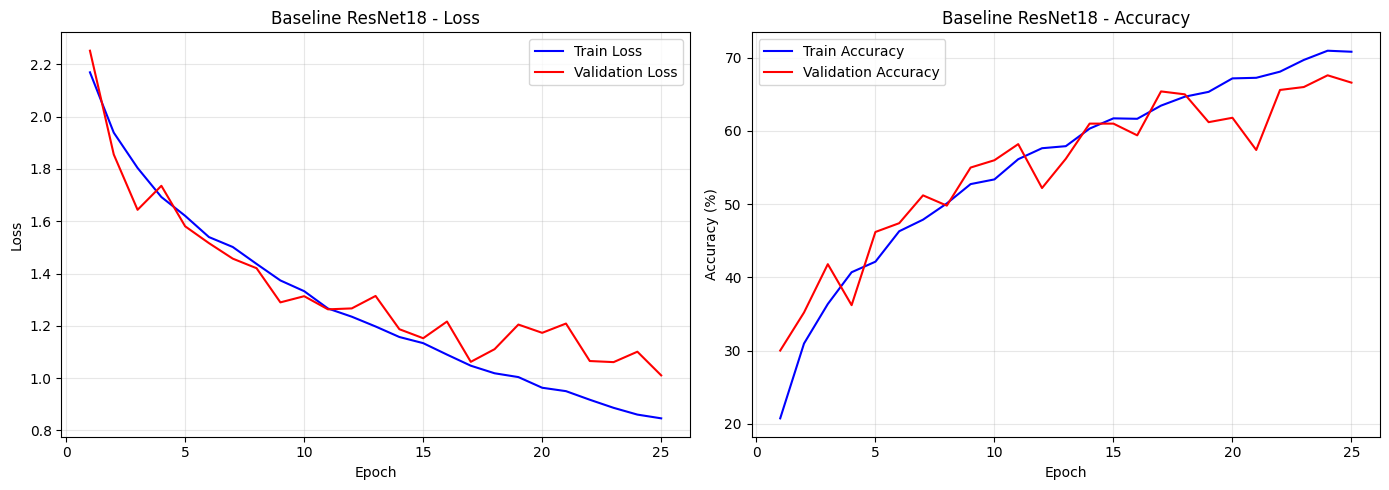

In [ ]:
baseline_model = ResNet18(num_classes=10, channels=[32, 64, 128, 256], num_blocks=[2, 2, 2, 2], activation='relu').to(device)
print(f"Архитектура базовой модели:\n{baseline_model}\n\n Количество параметров: {count_parameters(baseline_model):,}")
optimizer = optim.Adam(baseline_model.parameters(), lr=LEARNING_RATE)
trainer = Trainer(baseline_model, train_loader, val_loader, criterion, optimizer, device, model_name='baseline')
baseline_history = trainer.train(NUM_EPOCHS)
all_results['Baseline'] = baseline_history
plot_training_curves(baseline_history, 'Baseline ResNet18', save_path='baseline_curves.png')

### 3.1: Оптимизация количества каналов

Исследовалось влияние числа каналов в слоях: вариант A с каналами 32-64-128-256 и вариант B с каналами 64-128-256 (без четвёртого слоя) при одинаковых гиперпараметрах. Вариант B при меньшей глубине продемонстрировал небольшое улучшение валидационной точности по сравнению с вариантом A, при сопоставимом количестве параметров, поэтому в дальнейших экспериментах он был выбран как предпочтительная конфигурация по каналам.

Вариант A: 32  64  128  256 каналов

 Обучение модели: 3_1_a
Количество параметров: 2,797,610
----------------------------------------------------------------------------------------------------


Epoch 1/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 1/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [1/25] Train Loss: 2.1541, Train Acc: 21.1800% | Val Loss: 2.3379, Val Acc: 20.2000%
Обновлена лучшая модель с Val Acc: 20.20%


Epoch 2/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 2/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [2/25] Train Loss: 2.0108, Train Acc: 26.5000% | Val Loss: 2.1598, Val Acc: 26.4000%
Обновлена лучшая модель с Val Acc: 26.40%


Epoch 3/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 3/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [3/25] Train Loss: 1.9089, Train Acc: 30.6600% | Val Loss: 1.8148, Val Acc: 36.0000%
Обновлена лучшая модель с Val Acc: 36.00%


Epoch 4/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 4/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [4/25] Train Loss: 1.8206, Train Acc: 34.8200% | Val Loss: 1.8697, Val Acc: 32.2000%


Epoch 5/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 5/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [5/25] Train Loss: 1.7501, Train Acc: 37.3600% | Val Loss: 1.6470, Val Acc: 41.4000%
Обновлена лучшая модель с Val Acc: 41.40%


Epoch 6/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 6/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [6/25] Train Loss: 1.6523, Train Acc: 40.2000% | Val Loss: 1.5854, Val Acc: 41.4000%


Epoch 7/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 7/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [7/25] Train Loss: 1.5818, Train Acc: 43.6800% | Val Loss: 1.5849, Val Acc: 43.2000%
Обновлена лучшая модель с Val Acc: 43.20%


Epoch 8/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 8/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [8/25] Train Loss: 1.5063, Train Acc: 46.2200% | Val Loss: 1.4271, Val Acc: 52.2000%
Обновлена лучшая модель с Val Acc: 52.20%


Epoch 9/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 9/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [9/25] Train Loss: 1.4292, Train Acc: 49.4600% | Val Loss: 1.4283, Val Acc: 50.0000%


Epoch 10/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 10/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [10/25] Train Loss: 1.3772, Train Acc: 51.5200% | Val Loss: 1.3249, Val Acc: 54.0000%
Обновлена лучшая модель с Val Acc: 54.00%


Epoch 11/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 11/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [11/25] Train Loss: 1.3246, Train Acc: 53.9800% | Val Loss: 1.3187, Val Acc: 55.0000%
Обновлена лучшая модель с Val Acc: 55.00%


Epoch 12/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 12/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [12/25] Train Loss: 1.2998, Train Acc: 54.6000% | Val Loss: 1.2884, Val Acc: 55.8000%
Обновлена лучшая модель с Val Acc: 55.80%


Epoch 13/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 13/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [13/25] Train Loss: 1.2566, Train Acc: 57.0600% | Val Loss: 1.2717, Val Acc: 56.4000%
Обновлена лучшая модель с Val Acc: 56.40%


Epoch 14/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 14/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [14/25] Train Loss: 1.2132, Train Acc: 57.5400% | Val Loss: 1.2628, Val Acc: 58.0000%
Обновлена лучшая модель с Val Acc: 58.00%


Epoch 15/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 15/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [15/25] Train Loss: 1.1731, Train Acc: 59.4200% | Val Loss: 1.2372, Val Acc: 60.4000%
Обновлена лучшая модель с Val Acc: 60.40%


Epoch 16/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 16/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [16/25] Train Loss: 1.1218, Train Acc: 60.9400% | Val Loss: 1.2728, Val Acc: 58.4000%


Epoch 17/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 17/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [17/25] Train Loss: 1.1092, Train Acc: 61.5400% | Val Loss: 1.1405, Val Acc: 59.8000%


Epoch 18/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 18/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [18/25] Train Loss: 1.0574, Train Acc: 63.5400% | Val Loss: 1.1986, Val Acc: 61.8000%
Обновлена лучшая модель с Val Acc: 61.80%


Epoch 19/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 19/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [19/25] Train Loss: 1.0490, Train Acc: 63.4200% | Val Loss: 1.1875, Val Acc: 59.4000%


Epoch 20/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 20/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [20/25] Train Loss: 1.0012, Train Acc: 65.0800% | Val Loss: 1.1948, Val Acc: 59.0000%


Epoch 21/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 21/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [21/25] Train Loss: 0.9800, Train Acc: 66.3400% | Val Loss: 1.1905, Val Acc: 61.0000%


Epoch 22/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 22/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [22/25] Train Loss: 0.9388, Train Acc: 67.6400% | Val Loss: 1.1501, Val Acc: 63.0000%
Обновлена лучшая модель с Val Acc: 63.00%


Epoch 23/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 23/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [23/25] Train Loss: 0.9129, Train Acc: 68.1800% | Val Loss: 1.2391, Val Acc: 63.0000%


Epoch 24/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 24/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [24/25] Train Loss: 0.9044, Train Acc: 68.7200% | Val Loss: 1.2085, Val Acc: 61.0000%


Epoch 25/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 25/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [25/25] Train Loss: 0.8596, Train Acc: 70.3600% | Val Loss: 1.1834, Val Acc: 63.6000%
Обновлена лучшая модель с Val Acc: 63.60%
----------------------------------------------------------------------------------------------------
Обучение завершено. Лучшая Val Accuracy: 63.60%
Вариант B: 64 128  256 каналов

 Обучение модели: 3_1_b
Количество параметров: 2,777,674
----------------------------------------------------------------------------------------------------


Epoch 1/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 1/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [1/25] Train Loss: 2.1072, Train Acc: 23.6400% | Val Loss: 1.9674, Val Acc: 27.0000%
Обновлена лучшая модель с Val Acc: 27.00%


Epoch 2/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 2/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [2/25] Train Loss: 1.9482, Train Acc: 29.1200% | Val Loss: 1.8870, Val Acc: 30.6000%
Обновлена лучшая модель с Val Acc: 30.60%


Epoch 3/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 3/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [3/25] Train Loss: 1.8646, Train Acc: 33.4400% | Val Loss: 1.8757, Val Acc: 35.8000%
Обновлена лучшая модель с Val Acc: 35.80%


Epoch 4/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 4/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [4/25] Train Loss: 1.7838, Train Acc: 37.0000% | Val Loss: 1.7296, Val Acc: 39.4000%
Обновлена лучшая модель с Val Acc: 39.40%


Epoch 5/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 5/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [5/25] Train Loss: 1.7105, Train Acc: 39.5600% | Val Loss: 1.7770, Val Acc: 37.8000%


Epoch 6/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 6/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [6/25] Train Loss: 1.6520, Train Acc: 41.6000% | Val Loss: 1.6406, Val Acc: 44.0000%
Обновлена лучшая модель с Val Acc: 44.00%


Epoch 7/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 7/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [7/25] Train Loss: 1.6207, Train Acc: 42.8800% | Val Loss: 1.6226, Val Acc: 45.2000%
Обновлена лучшая модель с Val Acc: 45.20%


Epoch 8/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 8/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [8/25] Train Loss: 1.5710, Train Acc: 45.1400% | Val Loss: 1.6953, Val Acc: 43.4000%


Epoch 9/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 9/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [9/25] Train Loss: 1.5028, Train Acc: 48.3000% | Val Loss: 1.5164, Val Acc: 50.2000%
Обновлена лучшая модель с Val Acc: 50.20%


Epoch 10/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 10/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [10/25] Train Loss: 1.4505, Train Acc: 49.5200% | Val Loss: 1.6443, Val Acc: 50.0000%


Epoch 11/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 11/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [11/25] Train Loss: 1.3977, Train Acc: 51.6200% | Val Loss: 1.4054, Val Acc: 51.0000%
Обновлена лучшая модель с Val Acc: 51.00%


Epoch 12/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 12/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [12/25] Train Loss: 1.3473, Train Acc: 54.0400% | Val Loss: 1.2908, Val Acc: 57.0000%
Обновлена лучшая модель с Val Acc: 57.00%


Epoch 13/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 13/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [13/25] Train Loss: 1.2878, Train Acc: 55.3400% | Val Loss: 1.3594, Val Acc: 55.4000%


Epoch 14/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 14/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [14/25] Train Loss: 1.2708, Train Acc: 56.2000% | Val Loss: 1.3370, Val Acc: 54.4000%


Epoch 15/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 15/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [15/25] Train Loss: 1.2186, Train Acc: 57.7000% | Val Loss: 1.3071, Val Acc: 57.2000%
Обновлена лучшая модель с Val Acc: 57.20%


Epoch 16/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 16/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [16/25] Train Loss: 1.1828, Train Acc: 59.7400% | Val Loss: 1.2820, Val Acc: 57.8000%
Обновлена лучшая модель с Val Acc: 57.80%


Epoch 17/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 17/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [17/25] Train Loss: 1.1459, Train Acc: 61.4200% | Val Loss: 1.3601, Val Acc: 55.8000%


Epoch 18/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 18/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [18/25] Train Loss: 1.1257, Train Acc: 62.0400% | Val Loss: 1.3715, Val Acc: 58.0000%
Обновлена лучшая модель с Val Acc: 58.00%


Epoch 19/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 19/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [19/25] Train Loss: 1.0998, Train Acc: 61.9800% | Val Loss: 1.2597, Val Acc: 60.4000%
Обновлена лучшая модель с Val Acc: 60.40%


Epoch 20/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 20/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [20/25] Train Loss: 1.0681, Train Acc: 64.0400% | Val Loss: 1.2606, Val Acc: 60.6000%
Обновлена лучшая модель с Val Acc: 60.60%


Epoch 21/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 21/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [21/25] Train Loss: 1.0535, Train Acc: 64.1400% | Val Loss: 1.2431, Val Acc: 61.4000%
Обновлена лучшая модель с Val Acc: 61.40%


Epoch 22/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 22/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [22/25] Train Loss: 1.0171, Train Acc: 65.3000% | Val Loss: 1.2396, Val Acc: 61.6000%
Обновлена лучшая модель с Val Acc: 61.60%


Epoch 23/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 23/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [23/25] Train Loss: 1.0126, Train Acc: 65.6000% | Val Loss: 1.1544, Val Acc: 64.8000%
Обновлена лучшая модель с Val Acc: 64.80%


Epoch 24/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 24/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [24/25] Train Loss: 0.9663, Train Acc: 67.7400% | Val Loss: 1.1483, Val Acc: 63.4000%


Epoch 25/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 25/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [25/25] Train Loss: 0.9413, Train Acc: 67.1400% | Val Loss: 1.2273, Val Acc: 60.0000%
----------------------------------------------------------------------------------------------------
Обучение завершено. Лучшая Val Accuracy: 64.80%


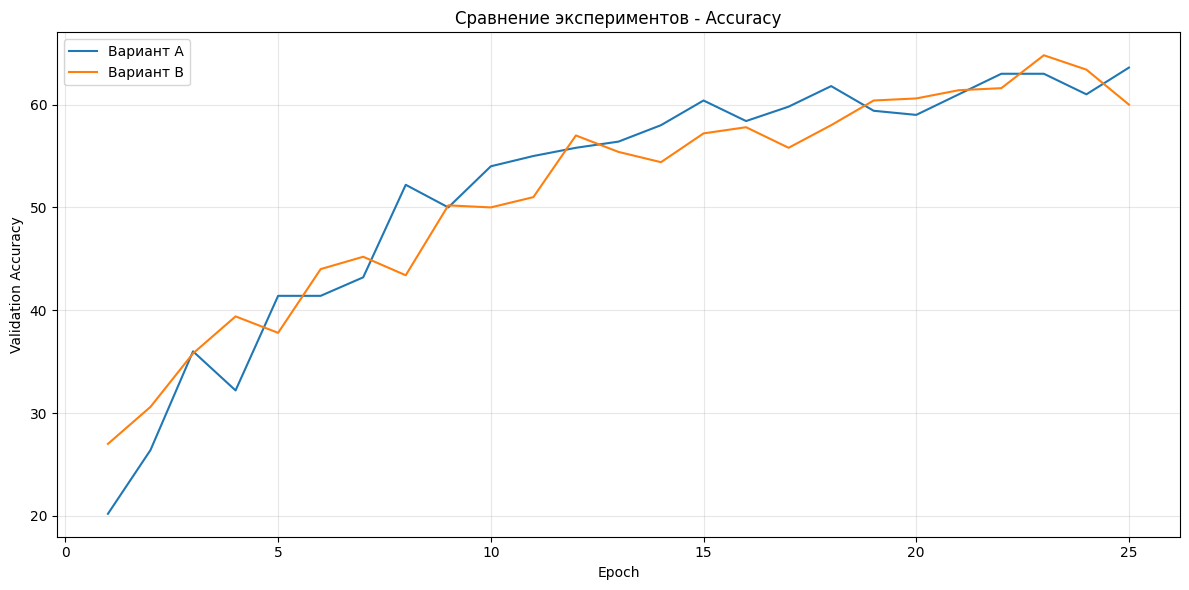

In [8]:
print('Вариант A: 32  64  128  256 каналов')
model_3_1_a = ResNet18(num_classes=10, channels=[32, 64, 128, 256], num_blocks=[2, 2, 2, 2], activation='relu').to(device)
optimizer_3_1_a = optim.Adam(model_3_1_a.parameters(), lr=LEARNING_RATE)
trainer_3_1_a = Trainer(model_3_1_a, train_loader, val_loader, criterion, optimizer_3_1_a, device, model_name='3_1_a')
history_3_1_a = trainer_3_1_a.train(NUM_EPOCHS)
all_results['3.1-A (32-64-128-256)'] = history_3_1_a


print('Вариант B: 64 128  256 каналов')
model_3_1_b = ResNet18(num_classes=10, channels=[64, 128, 256], num_blocks=[2, 2, 2,2], activation='relu').to(device)
optimizer_3_1_b = optim.Adam(model_3_1_b.parameters(), lr=LEARNING_RATE)
trainer_3_1_b = Trainer(model_3_1_b, train_loader, val_loader, criterion, optimizer_3_1_b, device, model_name='3_1_b')
history_3_1_b = trainer_3_1_b.train(NUM_EPOCHS)
all_results['3.1-B (64-128-256)'] = history_3_1_b


experiments_3_1 = {'Вариант A': history_3_1_a, 'Вариант B': history_3_1_b}
plot_multiple_experiments(experiments_3_1, metric='accuracy', save_path='3_1_comparison.png')

### 3.2: Эксперименты с количеством residual блоков

 На основе выбранных каналов (64-128-256) были сравнены три варианта глубины сети: по одному, два и три residual-блока в каждом слое. Эксперименты показали, что слишком мелкая сеть с одним блоком на слой обучается быстрее, но уступает по выходной валидационной точности, в то время как переход к двум и трём блокам дает прирост качества модели при умеренном увеличении числа параметров. Блы выбран вариант C [3, 3, 3, 3] с Val Accuracy 65.00%.

Вариант A: [1, 1, 1, 1] блоков

 Обучение модели: 3_2_a
Количество параметров: 1,227,594
----------------------------------------------------------------------------------------------------


Epoch 1/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 1/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [1/25] Train Loss: 2.0400, Train Acc: 26.9800% | Val Loss: 2.0148, Val Acc: 28.2000%
Обновлена лучшая модель с Val Acc: 28.20%


Epoch 2/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 2/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [2/25] Train Loss: 1.8917, Train Acc: 33.8800% | Val Loss: 1.9419, Val Acc: 36.8000%
Обновлена лучшая модель с Val Acc: 36.80%


Epoch 3/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 3/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [3/25] Train Loss: 1.7922, Train Acc: 37.4400% | Val Loss: 1.7944, Val Acc: 36.4000%


Epoch 4/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 4/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [4/25] Train Loss: 1.7156, Train Acc: 39.4400% | Val Loss: 1.7440, Val Acc: 40.0000%
Обновлена лучшая модель с Val Acc: 40.00%


Epoch 5/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 5/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [5/25] Train Loss: 1.6368, Train Acc: 43.0000% | Val Loss: 1.6772, Val Acc: 42.6000%
Обновлена лучшая модель с Val Acc: 42.60%


Epoch 6/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 6/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [6/25] Train Loss: 1.5838, Train Acc: 45.3600% | Val Loss: 1.6405, Val Acc: 44.6000%
Обновлена лучшая модель с Val Acc: 44.60%


Epoch 7/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 7/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [7/25] Train Loss: 1.5265, Train Acc: 47.2400% | Val Loss: 1.5404, Val Acc: 44.6000%


Epoch 8/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 8/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [8/25] Train Loss: 1.4684, Train Acc: 49.0200% | Val Loss: 1.4766, Val Acc: 51.8000%
Обновлена лучшая модель с Val Acc: 51.80%


Epoch 9/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 9/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [9/25] Train Loss: 1.4508, Train Acc: 49.9200% | Val Loss: 1.4664, Val Acc: 50.2000%


Epoch 10/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 10/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [10/25] Train Loss: 1.3888, Train Acc: 51.9800% | Val Loss: 1.4114, Val Acc: 51.4000%


Epoch 11/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 11/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [11/25] Train Loss: 1.3540, Train Acc: 53.4200% | Val Loss: 1.4058, Val Acc: 54.6000%
Обновлена лучшая модель с Val Acc: 54.60%


Epoch 12/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 12/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [12/25] Train Loss: 1.3250, Train Acc: 54.6600% | Val Loss: 1.4146, Val Acc: 53.0000%


Epoch 13/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 13/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [13/25] Train Loss: 1.2834, Train Acc: 56.2800% | Val Loss: 1.3823, Val Acc: 54.2000%


Epoch 14/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 14/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [14/25] Train Loss: 1.2527, Train Acc: 58.0800% | Val Loss: 1.4465, Val Acc: 52.8000%


Epoch 15/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 15/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [15/25] Train Loss: 1.2095, Train Acc: 58.9800% | Val Loss: 1.3365, Val Acc: 58.0000%
Обновлена лучшая модель с Val Acc: 58.00%


Epoch 16/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 16/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [16/25] Train Loss: 1.1947, Train Acc: 59.3200% | Val Loss: 1.2561, Val Acc: 58.8000%
Обновлена лучшая модель с Val Acc: 58.80%


Epoch 17/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 17/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [17/25] Train Loss: 1.1754, Train Acc: 60.5200% | Val Loss: 1.4388, Val Acc: 54.8000%


Epoch 18/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 18/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [18/25] Train Loss: 1.1486, Train Acc: 60.5600% | Val Loss: 1.3663, Val Acc: 58.0000%


Epoch 19/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 19/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [19/25] Train Loss: 1.1092, Train Acc: 62.5800% | Val Loss: 1.3141, Val Acc: 58.4000%


Epoch 20/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 20/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [20/25] Train Loss: 1.0904, Train Acc: 63.1000% | Val Loss: 1.2742, Val Acc: 60.8000%
Обновлена лучшая модель с Val Acc: 60.80%


Epoch 21/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 21/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [21/25] Train Loss: 1.0583, Train Acc: 64.4600% | Val Loss: 1.2785, Val Acc: 58.8000%


Epoch 22/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 22/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [22/25] Train Loss: 1.0608, Train Acc: 64.6600% | Val Loss: 1.2280, Val Acc: 60.0000%


Epoch 23/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 23/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [23/25] Train Loss: 1.0077, Train Acc: 65.7600% | Val Loss: 1.5232, Val Acc: 57.4000%


Epoch 24/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 24/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [24/25] Train Loss: 0.9846, Train Acc: 66.7200% | Val Loss: 1.4675, Val Acc: 60.8000%


Epoch 25/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 25/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [25/25] Train Loss: 0.9888, Train Acc: 67.0000% | Val Loss: 1.4496, Val Acc: 58.4000%
----------------------------------------------------------------------------------------------------
Обучение завершено. Лучшая Val Accuracy: 60.80%

 Вариант B: [2, 2, 2, 2] блоков

 Обучение модели: 3_2_b
Количество параметров: 2,777,674
----------------------------------------------------------------------------------------------------


Epoch 1/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 1/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [1/25] Train Loss: 2.1228, Train Acc: 24.2200% | Val Loss: 2.0356, Val Acc: 26.6000%
Обновлена лучшая модель с Val Acc: 26.60%


Epoch 2/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 2/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [2/25] Train Loss: 1.9503, Train Acc: 29.1600% | Val Loss: 1.8983, Val Acc: 35.0000%
Обновлена лучшая модель с Val Acc: 35.00%


Epoch 3/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 3/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [3/25] Train Loss: 1.8549, Train Acc: 33.9600% | Val Loss: 1.9812, Val Acc: 34.0000%


Epoch 4/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 4/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [4/25] Train Loss: 1.7655, Train Acc: 36.9800% | Val Loss: 1.7606, Val Acc: 42.0000%
Обновлена лучшая модель с Val Acc: 42.00%


Epoch 5/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 5/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [5/25] Train Loss: 1.6923, Train Acc: 40.6000% | Val Loss: 1.9379, Val Acc: 36.8000%


Epoch 6/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 6/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [6/25] Train Loss: 1.6252, Train Acc: 42.7600% | Val Loss: 1.7047, Val Acc: 41.4000%


Epoch 7/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 7/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [7/25] Train Loss: 1.5611, Train Acc: 44.4600% | Val Loss: 1.5696, Val Acc: 46.6000%
Обновлена лучшая модель с Val Acc: 46.60%


Epoch 8/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 8/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [8/25] Train Loss: 1.5151, Train Acc: 47.6400% | Val Loss: 1.5488, Val Acc: 47.0000%
Обновлена лучшая модель с Val Acc: 47.00%


Epoch 9/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 9/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [9/25] Train Loss: 1.4561, Train Acc: 48.7000% | Val Loss: 1.6565, Val Acc: 44.8000%


Epoch 10/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 10/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [10/25] Train Loss: 1.4051, Train Acc: 49.9600% | Val Loss: 1.3913, Val Acc: 49.0000%
Обновлена лучшая модель с Val Acc: 49.00%


Epoch 11/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 11/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [11/25] Train Loss: 1.3542, Train Acc: 53.1200% | Val Loss: 1.4293, Val Acc: 49.2000%
Обновлена лучшая модель с Val Acc: 49.20%


Epoch 12/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 12/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [12/25] Train Loss: 1.3114, Train Acc: 54.6000% | Val Loss: 1.4260, Val Acc: 53.2000%
Обновлена лучшая модель с Val Acc: 53.20%


Epoch 13/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 13/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [13/25] Train Loss: 1.2838, Train Acc: 55.0000% | Val Loss: 1.2900, Val Acc: 55.6000%
Обновлена лучшая модель с Val Acc: 55.60%


Epoch 14/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 14/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [14/25] Train Loss: 1.2345, Train Acc: 57.9000% | Val Loss: 1.2769, Val Acc: 56.4000%
Обновлена лучшая модель с Val Acc: 56.40%


Epoch 15/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 15/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [15/25] Train Loss: 1.2049, Train Acc: 58.6800% | Val Loss: 1.1812, Val Acc: 59.2000%
Обновлена лучшая модель с Val Acc: 59.20%


Epoch 16/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 16/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [16/25] Train Loss: 1.1802, Train Acc: 58.9600% | Val Loss: 1.2596, Val Acc: 56.8000%


Epoch 17/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 17/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [17/25] Train Loss: 1.1302, Train Acc: 60.9800% | Val Loss: 1.1732, Val Acc: 60.6000%
Обновлена лучшая модель с Val Acc: 60.60%


Epoch 18/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 18/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [18/25] Train Loss: 1.1142, Train Acc: 61.7400% | Val Loss: 1.2273, Val Acc: 60.2000%


Epoch 19/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 19/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [19/25] Train Loss: 1.0726, Train Acc: 62.8200% | Val Loss: 1.2488, Val Acc: 57.0000%


Epoch 20/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 20/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [20/25] Train Loss: 1.0447, Train Acc: 64.2000% | Val Loss: 1.2015, Val Acc: 61.4000%
Обновлена лучшая модель с Val Acc: 61.40%


Epoch 21/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 21/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [21/25] Train Loss: 1.0265, Train Acc: 65.1200% | Val Loss: 1.3169, Val Acc: 58.8000%


Epoch 22/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 22/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [22/25] Train Loss: 1.0095, Train Acc: 65.6400% | Val Loss: 1.1156, Val Acc: 62.6000%
Обновлена лучшая модель с Val Acc: 62.60%


Epoch 23/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 23/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [23/25] Train Loss: 0.9685, Train Acc: 67.1400% | Val Loss: 1.1067, Val Acc: 63.0000%
Обновлена лучшая модель с Val Acc: 63.00%


Epoch 24/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 24/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [24/25] Train Loss: 0.9464, Train Acc: 67.2400% | Val Loss: 1.2854, Val Acc: 59.4000%


Epoch 25/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 25/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [25/25] Train Loss: 0.9228, Train Acc: 68.5800% | Val Loss: 1.1667, Val Acc: 61.6000%
----------------------------------------------------------------------------------------------------
Обучение завершено. Лучшая Val Accuracy: 63.00%

 Вариант C: [3, 3, 3, 3] блоков

 Обучение модели: 3_2_c
Количество параметров: 4,327,754
----------------------------------------------------------------------------------------------------


Epoch 1/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 1/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [1/25] Train Loss: 2.1479, Train Acc: 22.6000% | Val Loss: 2.0653, Val Acc: 26.6000%
Обновлена лучшая модель с Val Acc: 26.60%


Epoch 2/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 2/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [2/25] Train Loss: 1.9934, Train Acc: 28.1200% | Val Loss: 2.0915, Val Acc: 26.2000%


Epoch 3/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 3/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [3/25] Train Loss: 1.8955, Train Acc: 31.0400% | Val Loss: 2.1070, Val Acc: 34.2000%
Обновлена лучшая модель с Val Acc: 34.20%


Epoch 4/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 4/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [4/25] Train Loss: 1.8140, Train Acc: 35.1800% | Val Loss: 1.7692, Val Acc: 40.8000%
Обновлена лучшая модель с Val Acc: 40.80%


Epoch 5/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 5/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [5/25] Train Loss: 1.7735, Train Acc: 36.5200% | Val Loss: 1.7399, Val Acc: 40.2000%


Epoch 6/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 6/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [6/25] Train Loss: 1.6871, Train Acc: 40.7200% | Val Loss: 1.7810, Val Acc: 38.8000%


Epoch 7/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 7/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [7/25] Train Loss: 1.6298, Train Acc: 42.1800% | Val Loss: 1.6481, Val Acc: 44.0000%
Обновлена лучшая модель с Val Acc: 44.00%


Epoch 8/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 8/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [8/25] Train Loss: 1.5747, Train Acc: 44.3600% | Val Loss: 1.5842, Val Acc: 45.6000%
Обновлена лучшая модель с Val Acc: 45.60%


Epoch 9/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 9/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [9/25] Train Loss: 1.4997, Train Acc: 46.5600% | Val Loss: 1.6012, Val Acc: 47.0000%
Обновлена лучшая модель с Val Acc: 47.00%


Epoch 10/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 10/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [10/25] Train Loss: 1.4792, Train Acc: 47.6000% | Val Loss: 1.4853, Val Acc: 49.4000%
Обновлена лучшая модель с Val Acc: 49.40%


Epoch 11/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 11/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [11/25] Train Loss: 1.4080, Train Acc: 50.2600% | Val Loss: 1.3763, Val Acc: 50.8000%
Обновлена лучшая модель с Val Acc: 50.80%


Epoch 12/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 12/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [12/25] Train Loss: 1.3548, Train Acc: 52.6600% | Val Loss: 1.3458, Val Acc: 54.4000%
Обновлена лучшая модель с Val Acc: 54.40%


Epoch 13/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 13/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [13/25] Train Loss: 1.3299, Train Acc: 54.1800% | Val Loss: 1.3276, Val Acc: 54.6000%
Обновлена лучшая модель с Val Acc: 54.60%


Epoch 14/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 14/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [14/25] Train Loss: 1.2668, Train Acc: 55.8200% | Val Loss: 1.4943, Val Acc: 52.2000%


Epoch 15/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 15/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [15/25] Train Loss: 1.2311, Train Acc: 57.0200% | Val Loss: 1.4710, Val Acc: 53.6000%


Epoch 16/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 16/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [16/25] Train Loss: 1.1940, Train Acc: 58.6200% | Val Loss: 1.2397, Val Acc: 60.6000%
Обновлена лучшая модель с Val Acc: 60.60%


Epoch 17/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 17/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [17/25] Train Loss: 1.1691, Train Acc: 60.0000% | Val Loss: 1.1960, Val Acc: 61.2000%
Обновлена лучшая модель с Val Acc: 61.20%


Epoch 18/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 18/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [18/25] Train Loss: 1.1359, Train Acc: 61.5400% | Val Loss: 1.2333, Val Acc: 59.6000%


Epoch 19/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 19/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [19/25] Train Loss: 1.1094, Train Acc: 61.9200% | Val Loss: 1.1168, Val Acc: 63.2000%
Обновлена лучшая модель с Val Acc: 63.20%


Epoch 20/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 20/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [20/25] Train Loss: 1.0678, Train Acc: 64.0000% | Val Loss: 1.2120, Val Acc: 61.6000%


Epoch 21/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 21/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [21/25] Train Loss: 1.0546, Train Acc: 63.0000% | Val Loss: 1.1810, Val Acc: 61.6000%


Epoch 22/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 22/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [22/25] Train Loss: 1.0136, Train Acc: 65.2200% | Val Loss: 1.2230, Val Acc: 59.0000%


Epoch 23/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 23/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [23/25] Train Loss: 0.9875, Train Acc: 65.4200% | Val Loss: 1.1136, Val Acc: 65.0000%
Обновлена лучшая модель с Val Acc: 65.00%


Epoch 24/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 24/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [24/25] Train Loss: 0.9573, Train Acc: 65.8600% | Val Loss: 1.1439, Val Acc: 63.8000%


Epoch 25/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 25/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [25/25] Train Loss: 0.9295, Train Acc: 68.6000% | Val Loss: 1.1419, Val Acc: 63.6000%
----------------------------------------------------------------------------------------------------
Обучение завершено. Лучшая Val Accuracy: 65.00%


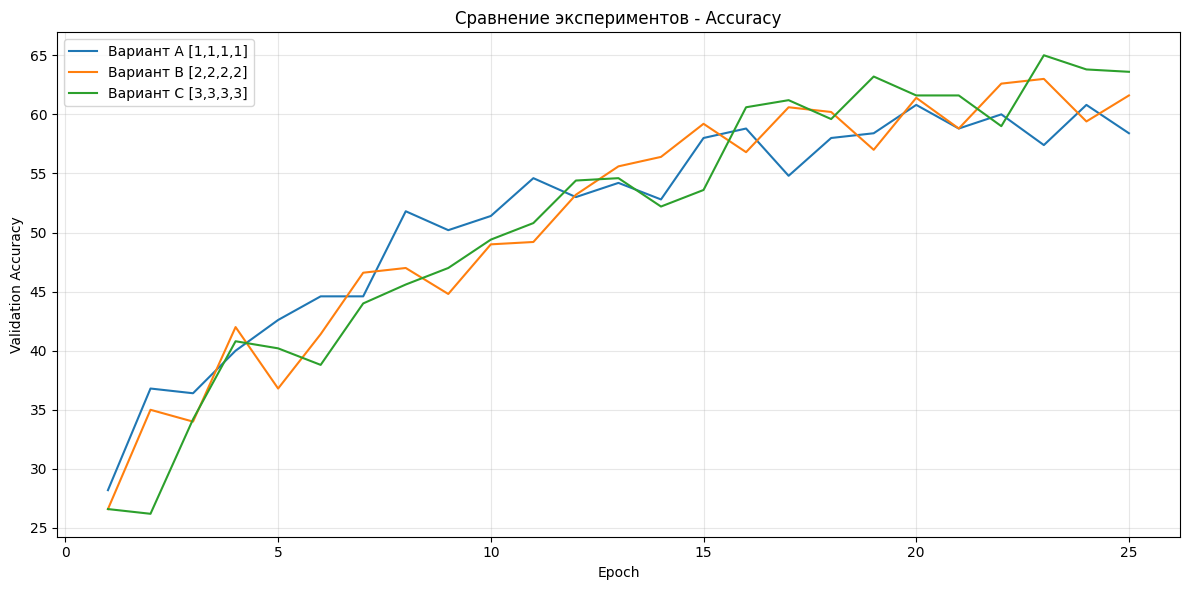

In [9]:


# BEST_CHANNELS_3_1 = [32, 64, 128, 256]

BEST_CHANNELS_3_1 = [64, 128, 256]

print('Вариант A: [1, 1, 1, 1] блоков')
model_3_2_a = ResNet18(num_classes=10, channels=BEST_CHANNELS_3_1, num_blocks=[1, 1, 1, 1], activation='relu').to(device)
optimizer_3_2_a = optim.Adam(model_3_2_a.parameters(), lr=LEARNING_RATE)
trainer_3_2_a = Trainer(model_3_2_a, train_loader, val_loader, criterion, optimizer_3_2_a, device, model_name='3_2_a')
history_3_2_a = trainer_3_2_a.train(NUM_EPOCHS)
all_results['3.2-A [1,1,1,1]'] = history_3_2_a


print('\n Вариант B: [2, 2, 2, 2] блоков')

model_3_2_b = ResNet18(num_classes=10, channels=BEST_CHANNELS_3_1, num_blocks=[2, 2, 2, 2], activation='relu').to(device)
optimizer_3_2_b = optim.Adam(model_3_2_b.parameters(), lr=LEARNING_RATE)
trainer_3_2_b = Trainer(model_3_2_b, train_loader, val_loader, criterion, optimizer_3_2_b, device, model_name='3_2_b')
history_3_2_b = trainer_3_2_b.train(NUM_EPOCHS)
all_results['3.2-B [2,2,2,2]'] = history_3_2_b

print('\n Вариант C: [3, 3, 3, 3] блоков')
model_3_2_c = ResNet18(num_classes=10, channels=BEST_CHANNELS_3_1, num_blocks=[3, 3, 3, 3], activation='relu').to(device)
optimizer_3_2_c = optim.Adam(model_3_2_c.parameters(), lr=LEARNING_RATE)
trainer_3_2_c = Trainer(model_3_2_c, train_loader, val_loader, criterion, optimizer_3_2_c, device, model_name='3_2_c')
history_3_2_c = trainer_3_2_c.train(NUM_EPOCHS)
all_results['3.2-C [3,3,3,3]'] = history_3_2_c


experiments_3_2 = {'Вариант A [1,1,1,1]': history_3_2_a, 'Вариант B [2,2,2,2]': history_3_2_b, 'Вариант C [3,3,3,3]': history_3_2_c}
plot_multiple_experiments(experiments_3_2, metric='accuracy', save_path='3_2_comparison.png')







### 3.3: Эксперименты с функциями активации

Далее сравнивались разные функции активации внутри residual-блоков. Брали ReLU как базовый вариант, плюс LeakyReLU, ELU и GELU. По динамике на кривых обучения и по финальной точности валидации, вариант  LeakyReLU вышел лучшим. Он дал самое быстрое и стабильную сходимость. Плюс на несколько процентов обогнал другие функции в Val Acc.


 Вариант: RELU

 Обучение модели: act_relu
Количество параметров: 4,327,754
----------------------------------------------------------------------------------------------------


Epoch 1/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 1/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [1/25] Train Loss: 2.1955, Train Acc: 20.2000% | Val Loss: 2.3016, Val Acc: 22.4000%
Обновлена лучшая модель с Val Acc: 22.40%


Epoch 2/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 2/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [2/25] Train Loss: 2.0552, Train Acc: 24.9200% | Val Loss: 2.0831, Val Acc: 28.2000%
Обновлена лучшая модель с Val Acc: 28.20%


Epoch 3/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 3/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [3/25] Train Loss: 1.9650, Train Acc: 29.7000% | Val Loss: 2.0464, Val Acc: 34.0000%
Обновлена лучшая модель с Val Acc: 34.00%


Epoch 4/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 4/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [4/25] Train Loss: 1.8822, Train Acc: 33.4400% | Val Loss: 1.9561, Val Acc: 31.8000%


Epoch 5/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 5/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [5/25] Train Loss: 1.7854, Train Acc: 37.4000% | Val Loss: 1.9032, Val Acc: 33.8000%


Epoch 6/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 6/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [6/25] Train Loss: 1.7177, Train Acc: 39.1400% | Val Loss: 1.8197, Val Acc: 41.6000%
Обновлена лучшая модель с Val Acc: 41.60%


Epoch 7/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 7/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [7/25] Train Loss: 1.6769, Train Acc: 40.8600% | Val Loss: 1.8083, Val Acc: 39.6000%


Epoch 8/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 8/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [8/25] Train Loss: 1.6330, Train Acc: 42.4200% | Val Loss: 1.8227, Val Acc: 40.8000%


Epoch 9/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 9/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [9/25] Train Loss: 1.5666, Train Acc: 44.2600% | Val Loss: 1.5640, Val Acc: 46.6000%
Обновлена лучшая модель с Val Acc: 46.60%


Epoch 10/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 10/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [10/25] Train Loss: 1.5242, Train Acc: 46.9200% | Val Loss: 2.0298, Val Acc: 45.8000%


Epoch 11/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 11/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [11/25] Train Loss: 1.4578, Train Acc: 49.6400% | Val Loss: 1.5328, Val Acc: 50.4000%
Обновлена лучшая модель с Val Acc: 50.40%


Epoch 12/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 12/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [12/25] Train Loss: 1.4165, Train Acc: 49.7000% | Val Loss: 1.4822, Val Acc: 52.2000%
Обновлена лучшая модель с Val Acc: 52.20%


Epoch 13/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 13/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [13/25] Train Loss: 1.3675, Train Acc: 52.5400% | Val Loss: 1.6020, Val Acc: 51.6000%


Epoch 14/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 14/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [14/25] Train Loss: 1.3289, Train Acc: 54.7400% | Val Loss: 1.4287, Val Acc: 53.2000%
Обновлена лучшая модель с Val Acc: 53.20%


Epoch 15/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 15/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [15/25] Train Loss: 1.2771, Train Acc: 55.8000% | Val Loss: 1.3781, Val Acc: 54.8000%
Обновлена лучшая модель с Val Acc: 54.80%


Epoch 16/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 16/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [16/25] Train Loss: 1.2387, Train Acc: 57.1000% | Val Loss: 1.3068, Val Acc: 55.2000%
Обновлена лучшая модель с Val Acc: 55.20%


Epoch 17/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 17/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [17/25] Train Loss: 1.2050, Train Acc: 58.6000% | Val Loss: 1.2597, Val Acc: 57.2000%
Обновлена лучшая модель с Val Acc: 57.20%


Epoch 18/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 18/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [18/25] Train Loss: 1.1832, Train Acc: 58.5800% | Val Loss: 1.2907, Val Acc: 58.2000%
Обновлена лучшая модель с Val Acc: 58.20%


Epoch 19/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 19/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [19/25] Train Loss: 1.1623, Train Acc: 59.7400% | Val Loss: 1.2097, Val Acc: 60.4000%
Обновлена лучшая модель с Val Acc: 60.40%


Epoch 20/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 20/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [20/25] Train Loss: 1.1318, Train Acc: 61.4400% | Val Loss: 1.2842, Val Acc: 57.8000%


Epoch 21/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 21/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [21/25] Train Loss: 1.0931, Train Acc: 63.0000% | Val Loss: 1.4726, Val Acc: 58.0000%


Epoch 22/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 22/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [22/25] Train Loss: 1.0722, Train Acc: 63.7000% | Val Loss: 1.4018, Val Acc: 58.6000%


Epoch 23/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 23/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [23/25] Train Loss: 1.0373, Train Acc: 64.3600% | Val Loss: 1.1406, Val Acc: 63.4000%
Обновлена лучшая модель с Val Acc: 63.40%


Epoch 24/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 24/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [24/25] Train Loss: 1.0120, Train Acc: 65.5800% | Val Loss: 1.1948, Val Acc: 62.4000%


Epoch 25/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 25/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [25/25] Train Loss: 0.9785, Train Acc: 66.8200% | Val Loss: 1.0965, Val Acc: 63.0000%
----------------------------------------------------------------------------------------------------
Обучение завершено. Лучшая Val Accuracy: 63.40%

 Вариант: LEAKYRELU

 Обучение модели: act_leakyrelu
Количество параметров: 4,327,754
----------------------------------------------------------------------------------------------------


Epoch 1/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 1/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [1/25] Train Loss: 2.1525, Train Acc: 21.4200% | Val Loss: 2.0454, Val Acc: 27.2000%
Обновлена лучшая модель с Val Acc: 27.20%


Epoch 2/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 2/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [2/25] Train Loss: 2.0084, Train Acc: 27.6600% | Val Loss: 1.9927, Val Acc: 28.8000%
Обновлена лучшая модель с Val Acc: 28.80%


Epoch 3/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 3/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [3/25] Train Loss: 1.9146, Train Acc: 32.0600% | Val Loss: 1.9048, Val Acc: 29.8000%
Обновлена лучшая модель с Val Acc: 29.80%


Epoch 4/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 4/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [4/25] Train Loss: 1.8463, Train Acc: 34.5400% | Val Loss: 1.8874, Val Acc: 33.2000%
Обновлена лучшая модель с Val Acc: 33.20%


Epoch 5/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 5/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [5/25] Train Loss: 1.7613, Train Acc: 37.2600% | Val Loss: 1.7225, Val Acc: 37.0000%
Обновлена лучшая модель с Val Acc: 37.00%


Epoch 6/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 6/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [6/25] Train Loss: 1.7179, Train Acc: 39.4600% | Val Loss: 1.7684, Val Acc: 39.6000%
Обновлена лучшая модель с Val Acc: 39.60%


Epoch 7/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 7/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [7/25] Train Loss: 1.6432, Train Acc: 41.7800% | Val Loss: 1.6333, Val Acc: 43.0000%
Обновлена лучшая модель с Val Acc: 43.00%


Epoch 8/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 8/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [8/25] Train Loss: 1.5841, Train Acc: 43.8800% | Val Loss: 1.6130, Val Acc: 45.4000%
Обновлена лучшая модель с Val Acc: 45.40%


Epoch 9/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 9/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [9/25] Train Loss: 1.5363, Train Acc: 46.1200% | Val Loss: 1.5393, Val Acc: 48.8000%
Обновлена лучшая модель с Val Acc: 48.80%


Epoch 10/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 10/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [10/25] Train Loss: 1.4744, Train Acc: 47.9200% | Val Loss: 1.4264, Val Acc: 50.0000%
Обновлена лучшая модель с Val Acc: 50.00%


Epoch 11/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 11/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [11/25] Train Loss: 1.4316, Train Acc: 50.1600% | Val Loss: 1.4125, Val Acc: 50.2000%
Обновлена лучшая модель с Val Acc: 50.20%


Epoch 12/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 12/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [12/25] Train Loss: 1.3587, Train Acc: 52.8000% | Val Loss: 1.6627, Val Acc: 46.6000%


Epoch 13/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 13/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [13/25] Train Loss: 1.3116, Train Acc: 54.1600% | Val Loss: 1.4348, Val Acc: 51.6000%
Обновлена лучшая модель с Val Acc: 51.60%


Epoch 14/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 14/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [14/25] Train Loss: 1.2938, Train Acc: 54.9000% | Val Loss: 1.3985, Val Acc: 52.0000%
Обновлена лучшая модель с Val Acc: 52.00%


Epoch 15/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 15/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [15/25] Train Loss: 1.2313, Train Acc: 57.7200% | Val Loss: 1.3481, Val Acc: 53.8000%
Обновлена лучшая модель с Val Acc: 53.80%


Epoch 16/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 16/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [16/25] Train Loss: 1.2038, Train Acc: 57.8200% | Val Loss: 1.3108, Val Acc: 55.8000%
Обновлена лучшая модель с Val Acc: 55.80%


Epoch 17/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 17/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [17/25] Train Loss: 1.1713, Train Acc: 59.7400% | Val Loss: 1.2098, Val Acc: 61.0000%
Обновлена лучшая модель с Val Acc: 61.00%


Epoch 18/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 18/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [18/25] Train Loss: 1.1261, Train Acc: 60.5400% | Val Loss: 1.2611, Val Acc: 57.2000%


Epoch 19/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 19/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [19/25] Train Loss: 1.0883, Train Acc: 62.8000% | Val Loss: 1.2046, Val Acc: 60.0000%


Epoch 20/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 20/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [20/25] Train Loss: 1.0646, Train Acc: 64.0000% | Val Loss: 1.1893, Val Acc: 60.2000%


Epoch 21/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 21/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [21/25] Train Loss: 1.0278, Train Acc: 65.0800% | Val Loss: 1.1362, Val Acc: 63.6000%
Обновлена лучшая модель с Val Acc: 63.60%


Epoch 22/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 22/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [22/25] Train Loss: 1.0041, Train Acc: 64.9200% | Val Loss: 1.1993, Val Acc: 60.8000%


Epoch 23/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 23/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [23/25] Train Loss: 0.9497, Train Acc: 67.2800% | Val Loss: 1.1130, Val Acc: 65.8000%
Обновлена лучшая модель с Val Acc: 65.80%


Epoch 24/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 24/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [24/25] Train Loss: 0.9315, Train Acc: 67.6200% | Val Loss: 1.1385, Val Acc: 62.6000%


Epoch 25/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 25/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [25/25] Train Loss: 0.9117, Train Acc: 69.0400% | Val Loss: 1.1301, Val Acc: 65.8000%
----------------------------------------------------------------------------------------------------
Обучение завершено. Лучшая Val Accuracy: 65.80%

 Вариант: ELU

 Обучение модели: act_elu
Количество параметров: 4,327,754
----------------------------------------------------------------------------------------------------


Epoch 1/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 1/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [1/25] Train Loss: 2.1798, Train Acc: 21.3600% | Val Loss: 2.1032, Val Acc: 22.8000%
Обновлена лучшая модель с Val Acc: 22.80%


Epoch 2/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 2/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [2/25] Train Loss: 2.0133, Train Acc: 25.3400% | Val Loss: 1.9813, Val Acc: 29.4000%
Обновлена лучшая модель с Val Acc: 29.40%


Epoch 3/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 3/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [3/25] Train Loss: 1.9330, Train Acc: 29.5200% | Val Loss: 1.8840, Val Acc: 28.8000%


Epoch 4/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 4/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [4/25] Train Loss: 1.8705, Train Acc: 32.9600% | Val Loss: 1.9180, Val Acc: 29.8000%
Обновлена лучшая модель с Val Acc: 29.80%


Epoch 5/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 5/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [5/25] Train Loss: 1.7923, Train Acc: 36.2000% | Val Loss: 1.7838, Val Acc: 33.8000%
Обновлена лучшая модель с Val Acc: 33.80%


Epoch 6/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 6/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [6/25] Train Loss: 1.7125, Train Acc: 39.1000% | Val Loss: 1.7910, Val Acc: 42.6000%
Обновлена лучшая модель с Val Acc: 42.60%


Epoch 7/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 7/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [7/25] Train Loss: 1.6821, Train Acc: 39.5800% | Val Loss: 1.5656, Val Acc: 45.0000%
Обновлена лучшая модель с Val Acc: 45.00%


Epoch 8/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 8/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [8/25] Train Loss: 1.6248, Train Acc: 42.9000% | Val Loss: 1.6567, Val Acc: 41.2000%


Epoch 9/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 9/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [9/25] Train Loss: 1.5912, Train Acc: 43.9600% | Val Loss: 1.5514, Val Acc: 47.0000%
Обновлена лучшая модель с Val Acc: 47.00%


Epoch 10/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 10/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [10/25] Train Loss: 1.5575, Train Acc: 45.7800% | Val Loss: 1.5495, Val Acc: 45.4000%


Epoch 11/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 11/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [11/25] Train Loss: 1.5042, Train Acc: 47.9200% | Val Loss: 1.4810, Val Acc: 48.8000%
Обновлена лучшая модель с Val Acc: 48.80%


Epoch 12/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 12/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [12/25] Train Loss: 1.4684, Train Acc: 49.0600% | Val Loss: 1.4397, Val Acc: 49.6000%
Обновлена лучшая модель с Val Acc: 49.60%


Epoch 13/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 13/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [13/25] Train Loss: 1.4204, Train Acc: 50.6000% | Val Loss: 1.4339, Val Acc: 49.8000%
Обновлена лучшая модель с Val Acc: 49.80%


Epoch 14/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 14/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [14/25] Train Loss: 1.3882, Train Acc: 52.1600% | Val Loss: 1.4802, Val Acc: 47.0000%


Epoch 15/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 15/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [15/25] Train Loss: 1.3467, Train Acc: 54.1000% | Val Loss: 1.3884, Val Acc: 54.2000%
Обновлена лучшая модель с Val Acc: 54.20%


Epoch 16/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 16/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [16/25] Train Loss: 1.3091, Train Acc: 56.0000% | Val Loss: 1.3822, Val Acc: 54.2000%


Epoch 17/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 17/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [17/25] Train Loss: 1.2768, Train Acc: 57.0000% | Val Loss: 1.3463, Val Acc: 54.6000%
Обновлена лучшая модель с Val Acc: 54.60%


Epoch 18/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 18/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [18/25] Train Loss: 1.2563, Train Acc: 57.8200% | Val Loss: 1.3046, Val Acc: 55.8000%
Обновлена лучшая модель с Val Acc: 55.80%


Epoch 19/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 19/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [19/25] Train Loss: 1.1992, Train Acc: 59.1600% | Val Loss: 1.3027, Val Acc: 57.0000%
Обновлена лучшая модель с Val Acc: 57.00%


Epoch 20/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 20/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [20/25] Train Loss: 1.1715, Train Acc: 59.3400% | Val Loss: 1.2612, Val Acc: 56.2000%


Epoch 21/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 21/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [21/25] Train Loss: 1.1573, Train Acc: 60.1200% | Val Loss: 1.2513, Val Acc: 61.4000%
Обновлена лучшая модель с Val Acc: 61.40%


Epoch 22/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 22/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [22/25] Train Loss: 1.1179, Train Acc: 61.6200% | Val Loss: 1.2454, Val Acc: 57.6000%


Epoch 23/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 23/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [23/25] Train Loss: 1.1105, Train Acc: 62.2000% | Val Loss: 1.2347, Val Acc: 60.0000%


Epoch 24/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 24/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [24/25] Train Loss: 1.0817, Train Acc: 63.3600% | Val Loss: 1.1397, Val Acc: 61.8000%
Обновлена лучшая модель с Val Acc: 61.80%


Epoch 25/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 25/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [25/25] Train Loss: 1.0562, Train Acc: 63.9400% | Val Loss: 1.2182, Val Acc: 60.8000%
----------------------------------------------------------------------------------------------------
Обучение завершено. Лучшая Val Accuracy: 61.80%

 Вариант: GELU

 Обучение модели: act_gelu
Количество параметров: 4,327,754
----------------------------------------------------------------------------------------------------


Epoch 1/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 1/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [1/25] Train Loss: 2.1516, Train Acc: 22.0200% | Val Loss: 2.3498, Val Acc: 25.2000%
Обновлена лучшая модель с Val Acc: 25.20%


Epoch 2/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 2/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [2/25] Train Loss: 1.9518, Train Acc: 30.5800% | Val Loss: 2.1781, Val Acc: 32.6000%
Обновлена лучшая модель с Val Acc: 32.60%


Epoch 3/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 3/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [3/25] Train Loss: 1.8583, Train Acc: 33.7800% | Val Loss: 1.9128, Val Acc: 32.8000%
Обновлена лучшая модель с Val Acc: 32.80%


Epoch 4/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 4/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [4/25] Train Loss: 1.7815, Train Acc: 35.9400% | Val Loss: 2.0469, Val Acc: 33.8000%
Обновлена лучшая модель с Val Acc: 33.80%


Epoch 5/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 5/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [5/25] Train Loss: 1.7048, Train Acc: 39.1800% | Val Loss: 1.9704, Val Acc: 38.2000%
Обновлена лучшая модель с Val Acc: 38.20%


Epoch 6/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 6/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [6/25] Train Loss: 1.6417, Train Acc: 41.7800% | Val Loss: 1.7252, Val Acc: 42.2000%
Обновлена лучшая модель с Val Acc: 42.20%


Epoch 7/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 7/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [7/25] Train Loss: 1.5989, Train Acc: 43.5000% | Val Loss: 1.7188, Val Acc: 46.2000%
Обновлена лучшая модель с Val Acc: 46.20%


Epoch 8/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 8/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [8/25] Train Loss: 1.5809, Train Acc: 43.9000% | Val Loss: 1.5325, Val Acc: 44.4000%


Epoch 9/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 9/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [9/25] Train Loss: 1.4972, Train Acc: 46.6400% | Val Loss: 1.5988, Val Acc: 45.0000%


Epoch 10/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 10/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [10/25] Train Loss: 1.4626, Train Acc: 49.6200% | Val Loss: 1.5022, Val Acc: 50.2000%
Обновлена лучшая модель с Val Acc: 50.20%


Epoch 11/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 11/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [11/25] Train Loss: 1.4056, Train Acc: 50.7800% | Val Loss: 1.5476, Val Acc: 51.2000%
Обновлена лучшая модель с Val Acc: 51.20%


Epoch 12/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 12/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [12/25] Train Loss: 1.3569, Train Acc: 53.2600% | Val Loss: 1.4055, Val Acc: 52.2000%
Обновлена лучшая модель с Val Acc: 52.20%


Epoch 13/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 13/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [13/25] Train Loss: 1.2900, Train Acc: 55.5800% | Val Loss: 1.4834, Val Acc: 51.6000%


Epoch 14/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 14/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [14/25] Train Loss: 1.2707, Train Acc: 55.8200% | Val Loss: 1.2855, Val Acc: 56.6000%
Обновлена лучшая модель с Val Acc: 56.60%


Epoch 15/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 15/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [15/25] Train Loss: 1.2195, Train Acc: 57.6600% | Val Loss: 1.2750, Val Acc: 58.0000%
Обновлена лучшая модель с Val Acc: 58.00%


Epoch 16/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 16/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [16/25] Train Loss: 1.1939, Train Acc: 59.1600% | Val Loss: 1.2734, Val Acc: 59.2000%
Обновлена лучшая модель с Val Acc: 59.20%


Epoch 17/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 17/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [17/25] Train Loss: 1.1484, Train Acc: 60.1800% | Val Loss: 1.2436, Val Acc: 59.4000%
Обновлена лучшая модель с Val Acc: 59.40%


Epoch 18/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 18/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [18/25] Train Loss: 1.1208, Train Acc: 61.6000% | Val Loss: 1.3031, Val Acc: 59.6000%
Обновлена лучшая модель с Val Acc: 59.60%


Epoch 19/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 19/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [19/25] Train Loss: 1.0847, Train Acc: 62.3800% | Val Loss: 1.2953, Val Acc: 58.0000%


Epoch 20/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 20/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [20/25] Train Loss: 1.0460, Train Acc: 63.5400% | Val Loss: 1.1646, Val Acc: 59.0000%


Epoch 21/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 21/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [21/25] Train Loss: 1.0190, Train Acc: 65.5600% | Val Loss: 1.1937, Val Acc: 60.2000%
Обновлена лучшая модель с Val Acc: 60.20%


Epoch 22/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 22/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [22/25] Train Loss: 0.9927, Train Acc: 65.8200% | Val Loss: 1.4473, Val Acc: 58.2000%


Epoch 23/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 23/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [23/25] Train Loss: 0.9551, Train Acc: 67.6400% | Val Loss: 1.0911, Val Acc: 64.4000%
Обновлена лучшая модель с Val Acc: 64.40%


Epoch 24/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 24/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [24/25] Train Loss: 0.9292, Train Acc: 68.3400% | Val Loss: 1.1366, Val Acc: 61.8000%


Epoch 25/25 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 25/25 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [25/25] Train Loss: 0.8996, Train Acc: 69.3200% | Val Loss: 1.1176, Val Acc: 65.4000%
Обновлена лучшая модель с Val Acc: 65.40%
----------------------------------------------------------------------------------------------------
Обучение завершено. Лучшая Val Accuracy: 65.40%


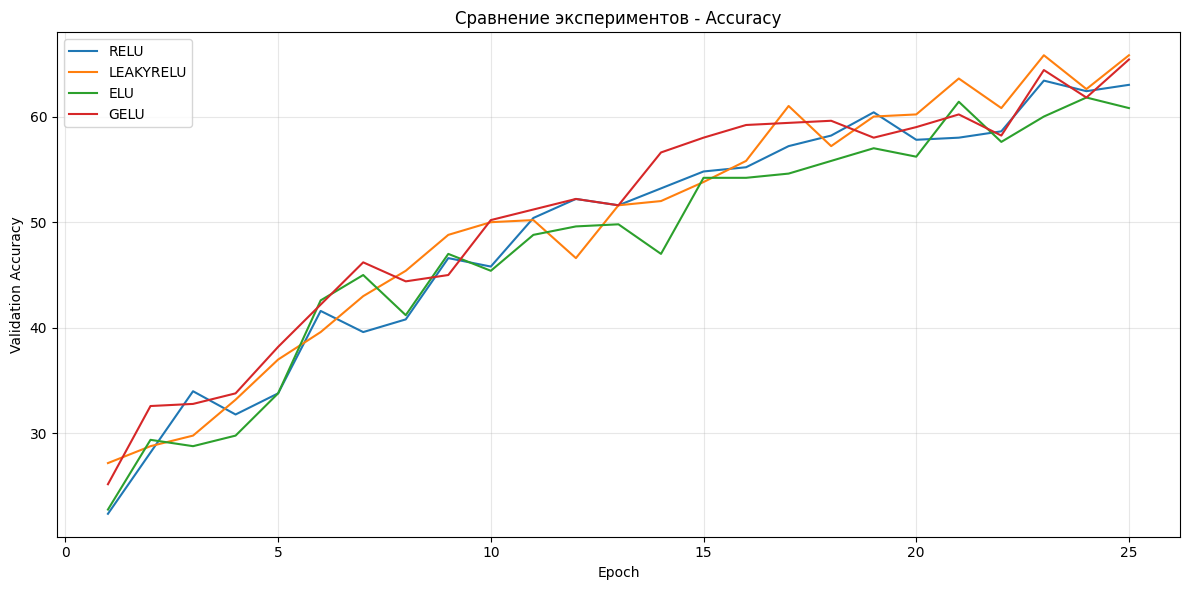

In [10]:
BEST_CHANNELS_3_2 = BEST_CHANNELS_3_1
BEST_BLOCKS_3_2 = [3, 3, 3, 3]

experiments_activations = {}



for act in ['relu','leakyrelu', 'elu', 'gelu']:
    act_name = act.upper()
    print(f'\n Вариант: {act_name}')
    model = ResNet18(num_classes=10, channels=BEST_CHANNELS_3_2, num_blocks=BEST_BLOCKS_3_2, activation=act).to(device)
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    trainer = Trainer(model, train_loader, val_loader, criterion, optimizer, device, model_name=f'act_{act}')
    history = trainer.train(NUM_EPOCHS)
    all_results[f'Activation-{act_name}'] = history
    experiments_activations[act_name] = history


plot_multiple_experiments(experiments_activations, metric='accuracy', save_path='activations_comparison.png')

## 4. Финальная модель и оценка

Лучшие параметры после экспериментов: channels=[64, 128, 256], num_blocks=[3, 3, 3, 3], activation='leakyrelu'


 Обучение модели: final_model
Количество параметров: 4,327,754
----------------------------------------------------------------------------------------------------


Epoch 1/40 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 1/40 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [1/40] Train Loss: 2.2075, Train Acc: 19.6200% | Val Loss: 2.1441, Val Acc: 23.6000%
Обновлена лучшая модель с Val Acc: 23.60%


Epoch 2/40 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 2/40 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [2/40] Train Loss: 2.0332, Train Acc: 25.8800% | Val Loss: 2.0289, Val Acc: 28.4000%
Обновлена лучшая модель с Val Acc: 28.40%


Epoch 3/40 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 3/40 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [3/40] Train Loss: 1.9186, Train Acc: 31.2800% | Val Loss: 1.9329, Val Acc: 33.0000%
Обновлена лучшая модель с Val Acc: 33.00%


Epoch 4/40 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 4/40 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [4/40] Train Loss: 1.8556, Train Acc: 34.5400% | Val Loss: 1.8744, Val Acc: 33.0000%


Epoch 5/40 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 5/40 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [5/40] Train Loss: 1.7668, Train Acc: 37.8000% | Val Loss: 1.7840, Val Acc: 36.4000%
Обновлена лучшая модель с Val Acc: 36.40%


Epoch 6/40 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 6/40 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [6/40] Train Loss: 1.7149, Train Acc: 39.6600% | Val Loss: 1.6196, Val Acc: 40.4000%
Обновлена лучшая модель с Val Acc: 40.40%


Epoch 7/40 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 7/40 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [7/40] Train Loss: 1.6450, Train Acc: 41.8800% | Val Loss: 1.6800, Val Acc: 40.6000%
Обновлена лучшая модель с Val Acc: 40.60%


Epoch 8/40 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 8/40 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [8/40] Train Loss: 1.5921, Train Acc: 44.1000% | Val Loss: 1.5252, Val Acc: 45.6000%
Обновлена лучшая модель с Val Acc: 45.60%


Epoch 9/40 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 9/40 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [9/40] Train Loss: 1.5359, Train Acc: 45.9600% | Val Loss: 1.5218, Val Acc: 47.0000%
Обновлена лучшая модель с Val Acc: 47.00%


Epoch 10/40 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 10/40 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [10/40] Train Loss: 1.4899, Train Acc: 48.0200% | Val Loss: 1.4380, Val Acc: 50.0000%
Обновлена лучшая модель с Val Acc: 50.00%


Epoch 11/40 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 11/40 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [11/40] Train Loss: 1.4236, Train Acc: 50.4400% | Val Loss: 1.4615, Val Acc: 51.4000%
Обновлена лучшая модель с Val Acc: 51.40%


Epoch 12/40 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 12/40 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [12/40] Train Loss: 1.3810, Train Acc: 51.8000% | Val Loss: 1.3572, Val Acc: 53.4000%
Обновлена лучшая модель с Val Acc: 53.40%


Epoch 13/40 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 13/40 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [13/40] Train Loss: 1.3234, Train Acc: 54.1600% | Val Loss: 1.3484, Val Acc: 52.8000%


Epoch 14/40 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 14/40 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [14/40] Train Loss: 1.2814, Train Acc: 56.9200% | Val Loss: 1.3516, Val Acc: 53.0000%


Epoch 15/40 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 15/40 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [15/40] Train Loss: 1.2407, Train Acc: 57.7000% | Val Loss: 1.3259, Val Acc: 52.8000%


Epoch 16/40 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 16/40 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [16/40] Train Loss: 1.2064, Train Acc: 58.4800% | Val Loss: 1.2617, Val Acc: 58.8000%
Обновлена лучшая модель с Val Acc: 58.80%


Epoch 17/40 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 17/40 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [17/40] Train Loss: 1.1710, Train Acc: 60.3200% | Val Loss: 1.1596, Val Acc: 60.6000%
Обновлена лучшая модель с Val Acc: 60.60%


Epoch 18/40 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 18/40 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [18/40] Train Loss: 1.1207, Train Acc: 61.3200% | Val Loss: 1.2273, Val Acc: 60.0000%


Epoch 19/40 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 19/40 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [19/40] Train Loss: 1.0953, Train Acc: 62.7400% | Val Loss: 1.1856, Val Acc: 59.4000%


Epoch 20/40 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 20/40 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [20/40] Train Loss: 1.0731, Train Acc: 63.5200% | Val Loss: 1.1057, Val Acc: 62.8000%
Обновлена лучшая модель с Val Acc: 62.80%


Epoch 21/40 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 21/40 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [21/40] Train Loss: 1.0349, Train Acc: 64.1800% | Val Loss: 1.1927, Val Acc: 61.2000%


Epoch 22/40 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 22/40 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [22/40] Train Loss: 1.0099, Train Acc: 65.9800% | Val Loss: 1.1766, Val Acc: 62.2000%


Epoch 23/40 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 23/40 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [23/40] Train Loss: 0.9615, Train Acc: 66.8000% | Val Loss: 1.1372, Val Acc: 62.6000%


Epoch 24/40 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 24/40 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [24/40] Train Loss: 0.9430, Train Acc: 67.2400% | Val Loss: 1.1819, Val Acc: 59.6000%


Epoch 25/40 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 25/40 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [25/40] Train Loss: 0.9261, Train Acc: 68.4800% | Val Loss: 1.2076, Val Acc: 62.0000%


Epoch 26/40 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 26/40 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [26/40] Train Loss: 0.8850, Train Acc: 69.4600% | Val Loss: 1.1648, Val Acc: 63.8000%
Обновлена лучшая модель с Val Acc: 63.80%


Epoch 27/40 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 27/40 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [27/40] Train Loss: 0.8768, Train Acc: 69.4400% | Val Loss: 1.1875, Val Acc: 62.6000%


Epoch 28/40 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 28/40 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [28/40] Train Loss: 0.8379, Train Acc: 71.6600% | Val Loss: 1.1570, Val Acc: 62.2000%


Epoch 29/40 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 29/40 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [29/40] Train Loss: 0.8151, Train Acc: 71.9200% | Val Loss: 1.1232, Val Acc: 65.4000%
Обновлена лучшая модель с Val Acc: 65.40%


Epoch 30/40 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 30/40 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [30/40] Train Loss: 0.7830, Train Acc: 73.3400% | Val Loss: 1.0059, Val Acc: 66.2000%
Обновлена лучшая модель с Val Acc: 66.20%


Epoch 31/40 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 31/40 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [31/40] Train Loss: 0.7623, Train Acc: 73.5200% | Val Loss: 1.0199, Val Acc: 66.6000%
Обновлена лучшая модель с Val Acc: 66.60%


Epoch 32/40 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 32/40 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [32/40] Train Loss: 0.7410, Train Acc: 74.6000% | Val Loss: 1.1258, Val Acc: 65.0000%


Epoch 33/40 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 33/40 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [33/40] Train Loss: 0.7043, Train Acc: 75.4800% | Val Loss: 1.0315, Val Acc: 68.2000%
Обновлена лучшая модель с Val Acc: 68.20%


Epoch 34/40 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 34/40 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [34/40] Train Loss: 0.6800, Train Acc: 76.8600% | Val Loss: 1.0134, Val Acc: 66.0000%


Epoch 35/40 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 35/40 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [35/40] Train Loss: 0.6672, Train Acc: 76.4400% | Val Loss: 1.1152, Val Acc: 67.2000%


Epoch 36/40 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 36/40 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [36/40] Train Loss: 0.6308, Train Acc: 78.7400% | Val Loss: 1.1655, Val Acc: 66.0000%


Epoch 37/40 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 37/40 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [37/40] Train Loss: 0.6193, Train Acc: 78.2400% | Val Loss: 0.9696, Val Acc: 70.0000%
Обновлена лучшая модель с Val Acc: 70.00%


Epoch 38/40 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 38/40 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [38/40] Train Loss: 0.5973, Train Acc: 78.4000% | Val Loss: 1.1380, Val Acc: 66.8000%


Epoch 39/40 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 39/40 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [39/40] Train Loss: 0.5687, Train Acc: 80.1400% | Val Loss: 1.1133, Val Acc: 67.0000%


Epoch 40/40 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 40/40 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]

Эпоха [40/40] Train Loss: 0.5435, Train Acc: 81.4000% | Val Loss: 1.1900, Val Acc: 67.0000%
----------------------------------------------------------------------------------------------------
Обучение завершено. Лучшая Val Accuracy: 70.00%


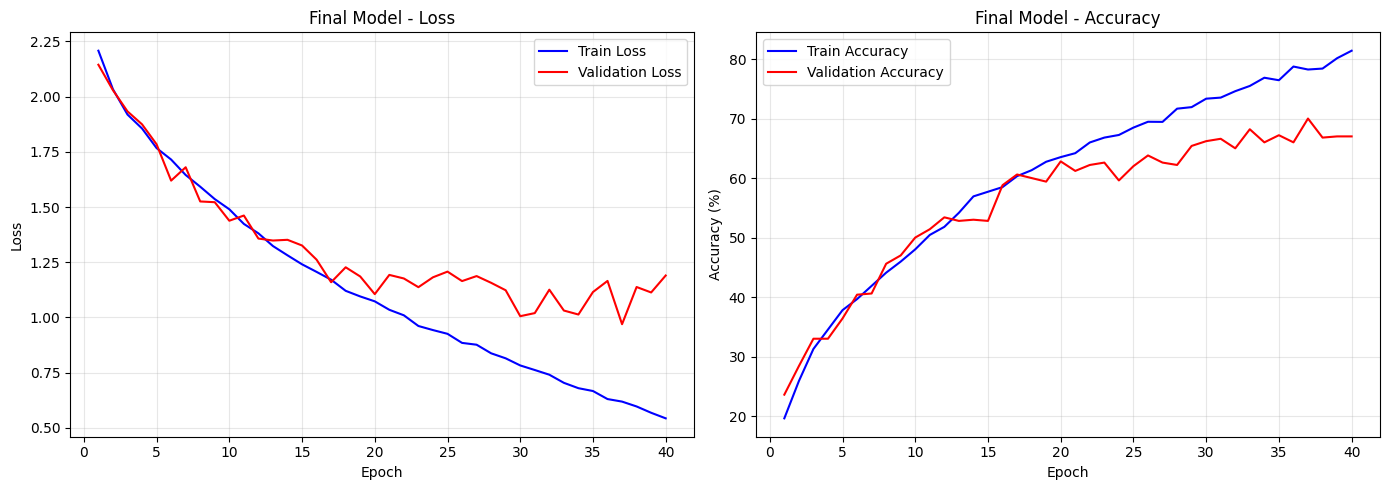

In [11]:
final_model = ResNet18(num_classes=10, channels=[64, 128, 256], num_blocks=[3, 3, 3, 3], activation='leakyrelu').to(device)
optimizer = optim.Adam(final_model.parameters(), lr=LEARNING_RATE)
trainer = Trainer(final_model, train_loader, val_loader, criterion, optimizer, device, model_name='final_model')
final_history = trainer.train(40)
all_results['Final Model'] = final_history
plot_training_curves(final_history, 'Final Model', save_path='final_model_curves.png')

Для выбранной финальной модели выполнена оценка на тестовом датасете Tiny ImageNet с расчётом общей точности, precision, recall и F1-score по каждому из 10 выбранных классов, а также построена confusion matrix.


Test Accuracy: 70.00%

              precision    recall  f1-score   support

    goldfish     0.9583    0.9200    0.9388        50
  salamander     0.8431    0.8600    0.8515        50
    bullfrog     0.5942    0.8200    0.6891        50
 tailed_frog     0.4706    0.3200    0.3810        50
   alligator     0.6792    0.7200    0.6990        50
         boa     0.5500    0.6600    0.6000        50
   trilobite     0.8113    0.8600    0.8350        50
    scorpion     0.5128    0.4000    0.4494        50
 black_widow     0.8511    0.8000    0.8247        50
   tarantula     0.6957    0.6400    0.6667        50

    accuracy                         0.7000       500
   macro avg     0.6966    0.7000    0.6935       500
weighted avg     0.6966    0.7000    0.6935       500



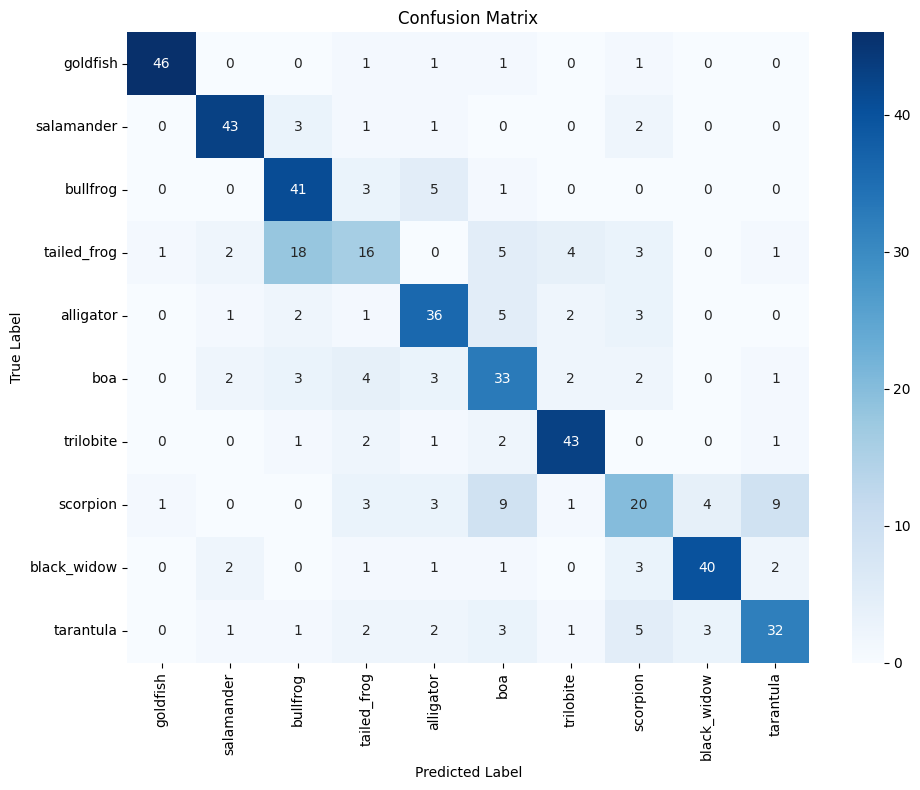

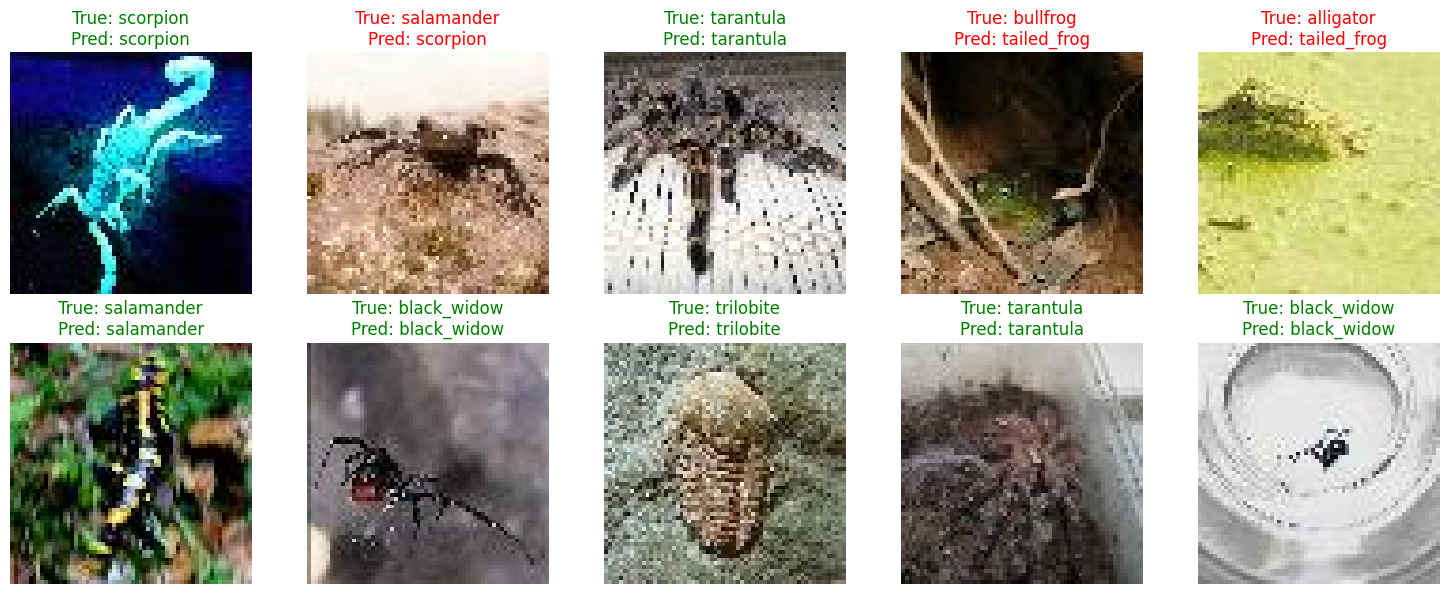

In [18]:
final_model.load_state_dict(torch.load('final_model_best.pth'))
evaluate_model(final_model, val_loader, device, CLASS_NAMES)
visualize_predictions(final_model, val_dataset, device, CLASS_NAMES, num_samples=10)

Полученные на тесте метрики оказались сопоставимы с валидационными, а анализ визуализации предсказаний на 10 случайных изображениях из датасета показали, что основная часть примеров классифицируется корректно.

In [13]:
results_table = []
for exp_name, history in all_results.items():
    results_table.append({'Эксперимент': exp_name, 'Val Accuracy': f"{history['best_val_acc']:.2f}%", 'Train Accuracy': f"{history['train_accs'][-1]:.2f}%", 'Parameters': f"{history['params']:,}" })
print("\n{:<30} {:<20} {:<20} {:<20}".format('Эксперимент', 'Val Accuracy', 'Train Accuracy', 'Parameters'))
print('__' * 52)
for row in results_table:
    print("{:<30} {:<20} {:<20} {:<20}".format(row['Эксперимент'], row['Val Accuracy'], row['Train Accuracy'], row['Parameters']))



Эксперимент                    Val Accuracy         Train Accuracy       Parameters          
________________________________________________________________________________________________________
Baseline                       67.60%               70.82%               2,797,610           
3.1-A (32-64-128-256)          63.60%               70.36%               2,797,610           
3.1-B (64-128-256)             64.80%               67.14%               2,777,674           
3.2-A [1,1,1,1]                60.80%               67.00%               1,227,594           
3.2-B [2,2,2,2]                63.00%               68.58%               2,777,674           
3.2-C [3,3,3,3]                65.00%               68.60%               4,327,754           
Activation-RELU                63.40%               66.82%               4,327,754           
Activation-LEAKYRELU           65.80%               69.04%               4,327,754           
Activation-ELU                 61.80%           

Сводная таблица всех экспериментов демонстрирует постепенное улучшение точности на валидационном наборе данных по мере усложнения архитектуры: от базовой ResNet18 к лучшим конфигурациям по каналам, глубине и активации, при этом рост числа параметров остаётся умеренным и не превышает заданный порог в 5 миллионов.

### Выводы
Процесс поэтапной оптимизации модели был успешным, позволив улучшить результат базовой модели с 67,60% до 70%. Вклад в улучшение внесли увеличение глубины сети до 3 3 3 3 блоков и выбор оптимальной функции активации LeakyReLU. Достигнутая точность в 70.00% показывает, что подбор архитектурных гиперпараметров, глубины, ширины, активации очень важен для максимизации производительности модели.
Разница у финальной модели между точностью на обучении 81,40% и валидации 70% составляет 11,4 процентов, что указывает на наличие умеренного переобучения. Это ожидаемо для глубокой модели с большим количеством параметров 4,3 миллиона на относительно небольшом наборе данных из 5000 картинок.